In [3]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from array import array
from sklearn.metrics import precision_score
import random
from matplotlib import pyplot as plt

## Data preprocessing

In [4]:
"""
this part is preprocessing data from csv file
"""
# train dataset - used for model to train itself
train_embedding = pd.read_csv('dataset/train_embedding.csv', sep=',', dtype=str).astype('float64').sort_values('Toxicity').iloc[-44972:, :]
train_embedding_comment = train_embedding.iloc[:,26:].values.tolist()
train_embedding_toxicity = train_embedding['Toxicity'].astype('int32').tolist()

x_train = train_embedding_comment
y_train = train_embedding_toxicity

# prediction dataset - used for model to make prediction and evaluate result
dev_embedding = pd.read_csv('dataset/dev_embedding.csv', sep=',', dtype=str).astype('float64').sort_values('Toxicity').iloc[-5670:, :]
dev_embedding_comment = dev_embedding.iloc[:,26:].values.tolist()
dev_embedding_toxicity = dev_embedding['Toxicity'].astype('int32').tolist()

x_predict = dev_embedding_comment
y_answer = dev_embedding_toxicity

# identifier dataset - used for one-r baseline
dev_embedding_identifier = dev_embedding.iloc[:,2:26].values.tolist()

# unlabeled dataset - used for unsupervised learning model and semi-supervising learning model
unlabeled_embedding = pd.read_csv('dataset/unlabeled_embedding.csv')
unlabeled_embedding_comment = unlabeled_embedding.iloc[:,1:].values.tolist()

# test dataset - used for producing kaggle competition result
test_embedding = pd.read_csv('dataset/test_embedding.csv')
test_embedding_comment = test_embedding.iloc[:,26:].values.tolist()

In [5]:
"""
this part is to demonstrate the label distribution of toxic and non-toxic labels from training dataset
"""

train_embedding.loc[:,"Toxicity"].value_counts()

0.0    22486
1.0    22486
Name: Toxicity, dtype: int64

In [6]:
"""
this part is to demonstrate the label distribution of toxic and non-toxic labels from prediction dataset
"""

dev_embedding.loc[:,"Toxicity"].value_counts()

0.0    2835
1.0    2835
Name: Toxicity, dtype: int64

## Logistic regression

In [8]:
"""
Preliminarily check naive bayes's performance against prediction dataset
"""

# logistic regression with pre defined c_vals

# c_values = [0.001]
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

accuracy_list = []
precision_list = []

curr_max = 0
best_c_val = 0

for c_val in c_values:
    lrclf = LogisticRegression(penalty='l1', solver='liblinear', C = c_val)
    lrclf.fit(x_train, y_train)
    pred = lrclf.predict(x_predict)
    accu_score = accuracy_score(y_answer, pred)
    pres_score = precision_score(y_answer, pred)

    accuracy_list.append(accu_score)
    precision_list.append(pres_score)

    if pres_score > curr_max:
        curr_max = pres_score
        best_c_val = c_val

print(best_c_val)
        

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1


In [10]:
# after obtain best c val, set up a new model and do classification report
lrclf = LogisticRegression(penalty='l1', solver='liblinear', C = 0.01)
lrclf.fit(x_train, y_train)
pred = lrclf.predict(x_predict)

print("LogisticRegression", classification_report(y_answer, pred, digits=4))

LogisticRegression               precision    recall  f1-score   support

           0     0.7608    0.6586    0.7060      2835
           1     0.6990    0.7929    0.7430      2835

    accuracy                         0.7257      5670
   macro avg     0.7299    0.7257    0.7245      5670
weighted avg     0.7299    0.7257    0.7245      5670



In [11]:
kaggle_predict = lr.predict(test_embedding_comment)
kaggle_predict_df = pd.DataFrame(kaggle_predict)
kaggle_predict_df.to_csv("50-50_LR_tuned_kaggle.csv")

## Logistic regression semi-supervised

In [12]:
"""
After comparing supervised learning models, choose Logistic Regression as the base model for semi-supervised learning
"""

base = LogisticRegression(penalty='l1', solver='liblinear', C = 1, max_iter=500)

In [13]:
def semi_super_lr(x_train,y_train):
    stclf = SelfTrainingClassifier(base)
    stclf.fit(x_train,y_train)
    pred = stclf.predict(x_predict)
    accu = accuracy_score(y_answer,pred)
    prec = precision_score(y_answer,pred,pos_label = 1)
    return accu,prec

In [14]:
unlabeled_embedding_comment_df = pd.DataFrame(unlabeled_embedding_comment)

In [15]:
"""
Designing a test to gradually feed unlabelled data to semi-super model, to find out the effectiveness
"""

def run_semi_super_lr():
    unlabeled_data_amount = []
    accu_log = []
    prec_log = []

    data_fractions = [0.001, 0.01, 0.1, 0.2, 0.5, 1]

    for a_fraction in data_fractions:

        x_train_unlabel = unlabeled_embedding_comment_df.sample(frac=a_fraction, random_state = 1)
        y_train_unlabel = []
        frac_size = 200000*a_fraction
        for i in range(int(frac_size)):
            y_train_unlabel.append(-1)

        # combine lablelled x with unlabelled x
        x_train_df = pd.DataFrame(x_train)
        x_train_cb = pd.concat([x_train_df, x_train_unlabel]).reset_index(drop = True)

        # combine lablelled y with unlabelled y
        y_train_df = pd.DataFrame(y_train)
        y_train_unlabel = pd.DataFrame(y_train_unlabel)
        y_train_cb = pd.concat([y_train_df, y_train_unlabel]).reset_index(drop = True)

        accu, prec = semi_super_lr(x_train_cb, y_train_cb)
        unlabeled_data_amount.append(frac_size)
        accu_log.append(accu)
        prec_log.append(prec)
    
    return unlabeled_data_amount, accu_log, prec_log

In [16]:
unlabeled_data_amount, accu_log, prec_log = run_semi_super_lr()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [17]:
unlabeled_data_amount

[200.0, 2000.0, 20000.0, 40000.0, 100000.0, 200000]

In [18]:
accu_log

[0.7261022927689594,
 0.7283950617283951,
 0.7329805996472664,
 0.7317460317460317,
 0.7283950617283951,
 0.7268077601410935]

In [19]:
prec_log

[0.6995641344956414,
 0.7034244423499842,
 0.7176276771004942,
 0.7213611859838275,
 0.7224321538990037,
 0.7217241379310345]

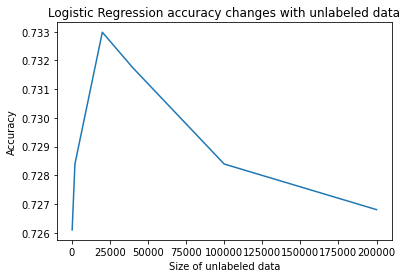

In [20]:
plt.plot(unlabeled_data_amount, accu_log)
plt.xlabel("Size of unlabeled data")
plt.ylabel("Accuracy")
plt.title("Logistic Regression accuracy changes with unlabeled data")
plt.show()

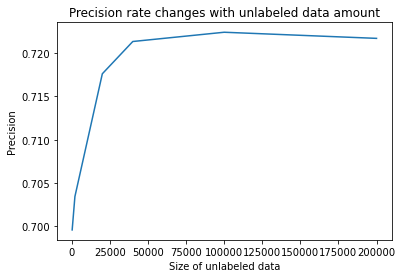

In [21]:
plt.plot(unlabeled_data_amount, prec_log)
plt.xlabel("Size of unlabeled data")
plt.ylabel("Precision")
plt.title("Precision rate changes with unlabeled data amount")
plt.show()

In [29]:
"""
To generate classification_report when unlabelled data amount is 20,000
"""
x_train_unlabel = unlabeled_embedding_comment_df.sample(frac=0.1, random_state = 1)
y_train_unlabel = []
frac_size = 20000
for i in range(int(frac_size)):
    y_train_unlabel.append(-1)

# combine lablelled x with unlabelled x
x_train_df = pd.DataFrame(x_train)
x_train_cb = pd.concat([x_train_df, x_train_unlabel]).reset_index(drop = True)

# combine lablelled y with unlabelled y
y_train_df = pd.DataFrame(y_train)
y_train_unlabel = pd.DataFrame(y_train_unlabel)
y_train_cb = pd.concat([y_train_df, y_train_unlabel]).reset_index(drop = True)

base = LogisticRegression(penalty='l1', solver='liblinear', C = 0.01)
stclf = SelfTrainingClassifier(base)
stclf.fit(x_train_cb,y_train_cb)
pred = stclf.predict(x_predict)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
print(classification_report(y_answer,pred,digits=4))

              precision    recall  f1-score   support

           0     0.7340    0.7026    0.7180      2835
           1     0.7148    0.7453    0.7298      2835

    accuracy                         0.7240      5670
   macro avg     0.7244    0.7240    0.7239      5670
weighted avg     0.7244    0.7240    0.7239      5670



In [28]:
"""
To predict on the test dataset for kaggle competition using semi-supervised learning
"""

"""
To generate classification_report when unlabelled data amount is 20,000
"""
x_train_unlabel = unlabeled_embedding_comment_df.sample(frac=0.1, random_state = 1)
y_train_unlabel = []
frac_size = 20000
for i in range(int(frac_size)):
    y_train_unlabel.append(-1)

# combine lablelled x with unlabelled x
x_train_df = pd.DataFrame(x_train)
x_train_cb = pd.concat([x_train_df, x_train_unlabel]).reset_index(drop = True)

# combine lablelled y with unlabelled y
y_train_df = pd.DataFrame(y_train)
y_train_unlabel = pd.DataFrame(y_train_unlabel)
y_train_cb = pd.concat([y_train_df, y_train_unlabel]).reset_index(drop = True)

base = LogisticRegression(penalty='l1', solver='liblinear', C = 0.01)
stclf = SelfTrainingClassifier(base)
stclf.fit(x_train_cb,y_train_cb)
pred = stclf.predict(test_embedding_comment)

kaggle_df = pd.DataFrame(pred)
kaggle_df.to_csv("50_50_kaggle_predicton_1.0_semi.csv")


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
